# Proyecto Pronóstico y predicción

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con el cliente basada en datos analíticos.
Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un cliente se haya ido: puede que se vaya de puntillas.
Los indicadores de pérdida varían de un campo a otro. Si un usuario compra en una tienda en línea con poca frecuencia pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor se haya aburrido y te haya abandonado.
En el caso de un gimnasio, tiene sentido decir que un cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.
Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.
Tienes que:
- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente
- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales
- Analizar los factores que más impactan la pérdida
- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    - Identificar a los grupos objetivo
    - Sugerir medidas para reducir la rotación
    - Describir cualquier otro patrón que observes con respecto a la interacción con los clientes


In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Tabla de contenidos <a id='back'></a>

1. [Descarga de datos y preparación](#descarga_datos)
2. [Análisis exploratorio de datos (EDA)](#eda)
3. [Modelo para predecir la cancelación de usuarios](#modelo_cancelacion)
4. [Clústeres de usuarios](#clusters)
5. [Conclusiones y recomendaciones](#conclusiones_recomendaciones)

## Descarga de datos y preparación <a id="descarga_datos"></a>

Vamos a cargar los datos del dataset `gym_churn_us.csv`

In [2]:
# Carga los archivos de datos
data = pd.read_csv('../data/gym_churn_us.csv')

# Verificamos que los datos se hayan cargado correctamente
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Vamos a estudiar los datos que contiene nuestro dataset y verificar que los tipos de datos sean correctos para nuestro análisis

In [3]:
# Imprimimos la información general/resumen sobre nuestro dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Nuestro dataset `data` que son los datos sobre la cancelación de un mes en concreto e información del mes que lo precedía de Model Fitness, contiene los siguientes datos:

- `Churn`: la cancelación para el mes en cuestión
- Campos de dataset actuales:
    - `gender`: género del cliente
    - `Near_Location`: si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio
    - `Partner`: si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)
    - `Promo_friends`: si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono)
    - `Phone`: si el usuario aportó el número de teléfono
    - `Age`: edad del cliente
    - `Lifetime`: el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía
    - `Contract_period`: periodo del contrato (1 mes, 3 meses, 6 meses o 1 año)
    - `Month_to_end_contract`: los meses que faltan hasta que expire el contrato
    - `Group_visits`: si el usuario participa en sesiones grupales
    - `Avg_class_frequency_total`: frecuencia media de visitas por semana a lo largo de la vida del cliente
    - `Avg_class_frequency_current_month`: frecuencia media de visitas por semana durante el mes en curso
    - `Avg_additional_charges_total`: cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [4]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en el dataset:', data.duplicated().sum())

Datos duplicados en el dataset: 0


In [5]:
# Se imprime una descripción de los datos numericos
data[['Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_current_month', 'Avg_class_frequency_total', 'Avg_additional_charges_total']].describe()

,Age,Lifetime,Contract_period,Month_to_end_contract,Avg_class_frequency_current_month,Avg_class_frequency_total,Avg_additional_charges_total
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,3.724750,4.681250,4.322750,1.767052,1.879020,146.943728
std,3.258367,3.749267,4.549706,4.191297,1.052906,0.972245,96.355602
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.148205
25%,27.000000,1.000000,1.000000,1.000000,0.963003,1.180875,68.868830
50%,29.000000,3.000000,1.000000,1.000000,1.719574,1.832768,136.220159
75%,31.000000,5.000000,6.000000,6.000000,2.510336,2.536078,210.949625
max,41.000000,31.000000,12.000000,12.000000,6.146783,6.023668,552.590740


#### Conclusiones del dataset

Al ver la muestra y resumen del dataset, no encontramos duplicados ni ausentes. Sin embargo es necesario ajustar los nombres de las columnas al estilo snake_case para facilitar el uso y llamado en procesos posteriores. Por último, gracias a la descripción de los datos númericos vemos que la mayoria de las columnas no presentan datos outliers, las unicas a tener cierta precaución serian `contract_period`, `month_to_end_contract` y `avg_additional_charges_total` ya que sus medias tienen diferencias un poco significativas con sus medianas.

### Corregir datos

In [6]:
# Cambiar los nombres de las columnas
data.columns = data.columns.str.lower()
# Verficamos los cambios
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Con estas correcciones, nuestro dataset está listo para nuestro análisis.

## Análisis exploratorio de datos (EDA)<a id="eda"></a>

Vamos a realizar las siguientes tareas en esta fase:

- Observa el dataset: ¿contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar.
- Observa los valores medios de las características en dos grupos: para los que se fueron (cancelación) y para los que se quedaron
- Trazar histogramas de barras y distribuciones de características para aquellos que se fueron (cancelación) y para los que se quedaron.
- Crea una matriz de correlación y mostrarla.

In [7]:
# Estudiar los valores promedio y la desviación estándar
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Podemos notar que la mayoria de las caracteristicas su desviación estandar no es mayor a 0.5, sin embargo tenemos algunas con cierta desviacion; la mayor de estas es la caracteristica de `avg_additional_charges_total` con una desviacion de 96.

In [8]:
# Observar los valores medios de la caracteristicas por grupos
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


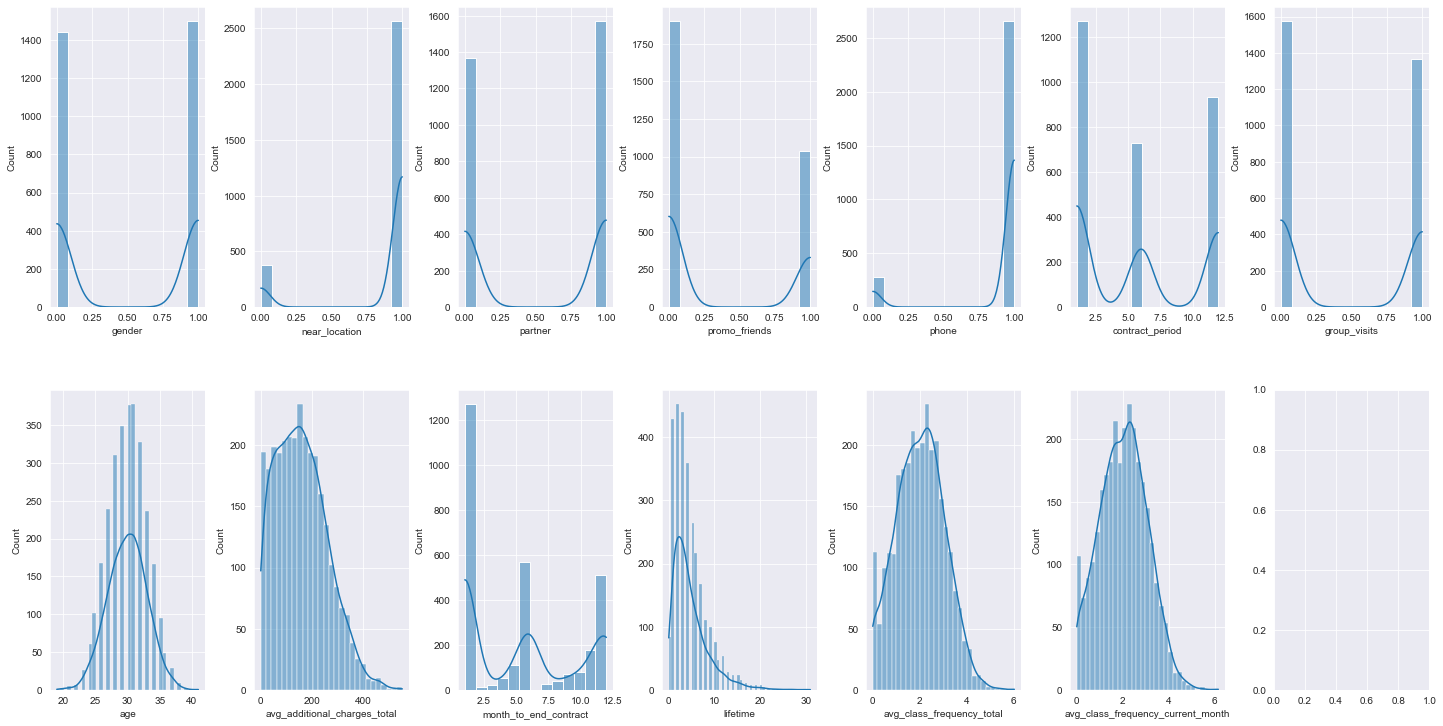

In [9]:
# Datos de clientes que se quedaron y que se fueron
data_left = data.query('churn == 1').drop(columns=['churn'])
data_stay = data.query('churn == 0').drop(columns=['churn'])

# Graficas de clientes que se quedaron
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in data_stay.items():
    sns.histplot(data=data_stay, x=v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

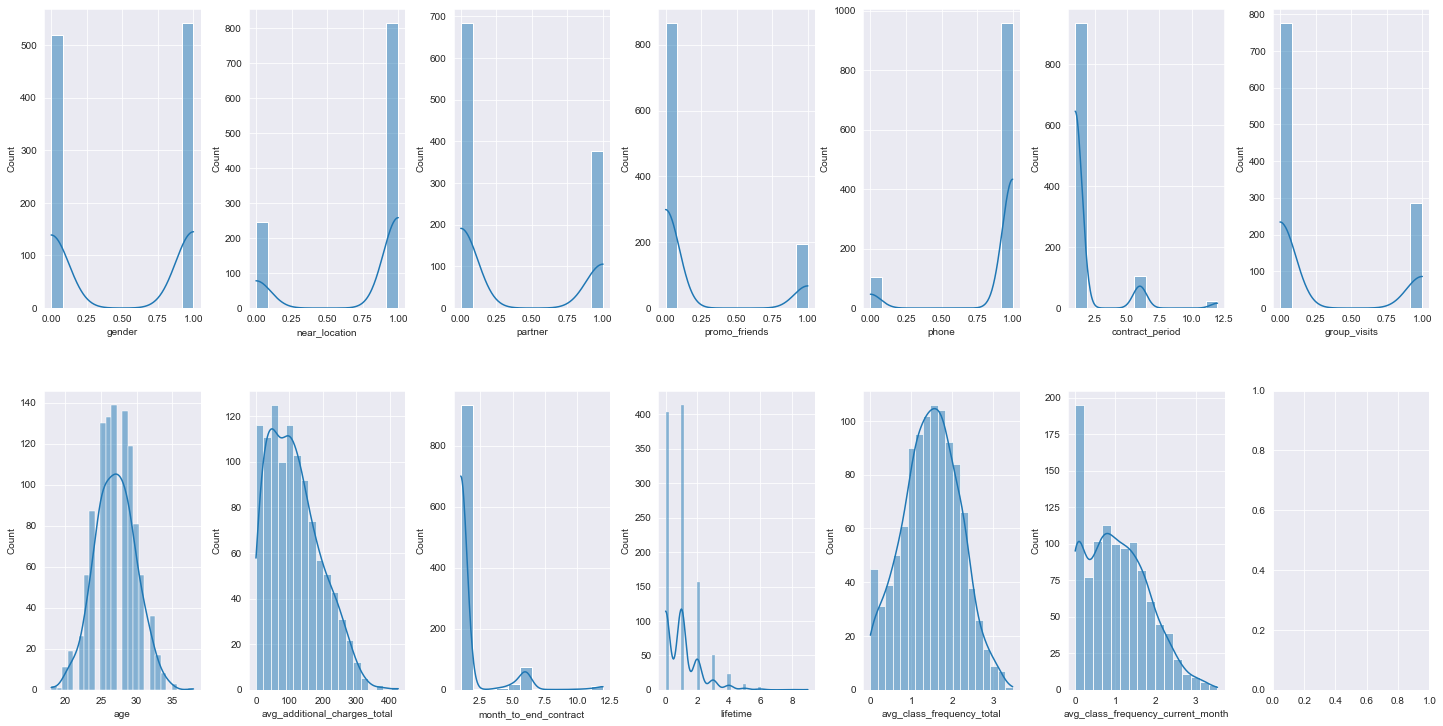

In [10]:
# Graficas de clientes que se fueron
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in data_left.items():
    sns.histplot(data=data_left, x=v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Conclusiones intermedias

Gracias a los valores y las graficas podemos dar las siguientes conclusiones de las caracteristicas:

1) Tenemos casi dividido en 50/50 el genero de ambos grupos
2) En ambos grupos, tenemos mayor número de clientes que viven cerca
3) El grupo que no deserto tiene mayor proporcion de clientes que son empleados de empresas asociadas o que ocuparon la promocion de amigos vs el grupo que deserto; sin embargo en ambos grupos es mayor la gente que no pertenece a empresa asociada o ocupo la promocion de amigo (a excepcion del grupo que no deserto donde las personas que pertenecen a una empresa asociada es mayor por poco)
4) En ambos grupos, la mayoria de los usuarios colocaron un telefono
5) El grupo que no deserto tiene una media de periodo de contrato de casi 6 meses vs el grupo que deserto que su media de contrato es en su mayoria de 1 mes
6) El grupo que no deserto tiene mayor proporcion de clientes que hacen visitas en grupo vs el grupo que deserto; sin embargo en ambos grupos es mayor la gente que no vino en grupo
7) La edad media entre el grupo que no deserto es de 30 años mientras que la del grupo que deserto es de 27 años
8) El gasto adicional de la gente que no deserto es de $158 mientras que la del grupo que deserto es menor con $115
9) El tiempo promedio de vida del grupo que no deserto es de 5 meses mientras que el del grupo que deserto es de solo un mes
10) El grupo que no deserto tiene un promedio de visitas a la semana de 2 (tanto en el mes como en su tiempo de vida) mientras que el grupo que deserto tiene un promedio de una clase.

<AxesSubplot:>

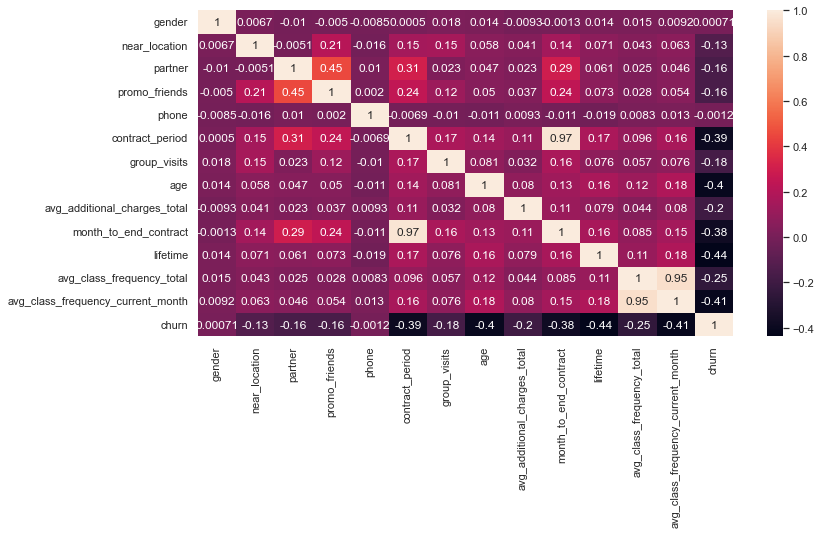

In [11]:
# Matriz de correlacion
cm = data.corr()
sns.set(rc={"figure.figsize":(12, 6)})
sns.heatmap(cm, annot = True)

En general podemos ver que hay pocas caracteristicas con un nivel de correlación muy alto, las unicas que se identifican son 2 pares `contract_period` con `month_to_end_contract` y `avg_class_frequency_current_month` con `avg_class_frequency_total`. Sin embargo, se puede ver claramente el porque de su relacion tan fuerte. Con nuestra variable objetivo podemos ver que las correlaciones más fuertes son negativas y son con las caracteristicas `contract_period`, `age`, `month_to_end_contract`, `lifetime` y `avg_class_frequency_current_month`

## Modelo para predecir la cancelación de usuarios<a id="modelo_cancelacion"></a>

Para esta fase se debe crear un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario el mes siguiente.
Se deben cumplir los siguientes pasos:

- Divide los datos en conjuntos de entrenamiento y validación
- Entrena el modelo en el set de entrenamiento con dos métodos:
    - Regresión logística
    - Bosque aleatorio
- Evalúa la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Utilízalos para comparar los modelos. ¿Qué modelo dio mejores resultados?

In [12]:
# Dividimos los datos en caracteristicas y variable objetivo
X = data.drop('churn', axis = 1)
y = data['churn']

# divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# Estandarizacion de las caracteristicas
scaler = StandardScaler()
# entrena el scaler en el conjunto de entrenamiento utilizando el método fit
scaler.fit(X_train)
# estandarizar el conjunto de entrenamiento utilizando el método transform scaler
X_train_st = scaler.transform(X_train)
# estandarizar el conjunto de validación utilizando el método transform scaler
X_test_st = scaler.transform(X_test)

In [14]:
# define la lista de modelos
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0, n_estimators=150)]

# la función que toma el modelo y los datos en las métricas input y output
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Exactitud:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(accuracy_score(y_test, y_pred),
                                                                    precision_score(y_test, y_pred),
                                                                    recall_score(y_test, y_pred)))

# escribe un bucle que genere métricas según la lista de modelos
for i in models:
    print('Algoritmo utilizado:', i)
    make_prediction(m=i,X_train = X_train_st, y_train= y_train,
                    X_test=X_test_st, y_test = y_test)
    print()

Algoritmo utilizado: LogisticRegression(random_state=0)
Exactitud:0.92 Precision:0.85 Recall:0.83 

Algoritmo utilizado: RandomForestClassifier(n_estimators=150, random_state=0)
Exactitud:0.92 Precision:0.85 Recall:0.83 



### Conclusiones prediccion de cancelacion de usuarios

Para la realización de nuestros modelos, se realizo la estandarización de los datos como preprocesamiento y en resultados, ambos modelos dieron exactamente los mismos resultados en las 3 métricas:

- Ambos modelos obtuvieron un 0.92 en exactitud; lo cual nos indica que tenemos una proporcion del 92% de predicciones exactas entre todas las predicciones.
- Ambos modelos obtuvieron un 0.85 en precisión; lo cual nos indica que del total de positivos el 85% fueron predichos correctamente.
- Ambos modelos obtuvieron un 0.83 en recall; lo cual nos indica que del total de positivos y falsos negativos el 83% fue predicho correctamente.

En general, ambos modelos consiguieron excelentes resultados superiores al 80% por lo que se puede elegir cualquiera de ellos para nuestro modelo final

## Clústeres de usuarios<a id="clusters"></a>

En este apartado identificaremos los clusteres de usuarios que tenemos, para ello se deben realizar las siguientes tareas:

- Estandarizar los datos.
- Crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. Utiliza el gráfico resultante para estimar el número de clústeres que puedes destacar.
- Entrena el modelo de clustering con el algortimo K-means y predice los clústeres de clientes.
- Mira los valores medios de característica para clústeres. ¿Hay algo que te llame la atención?
- Traza distribuciones de características para los clústeres. ¿Notas algo?
- Calcula la tasa de cancelación para cada clúster. ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

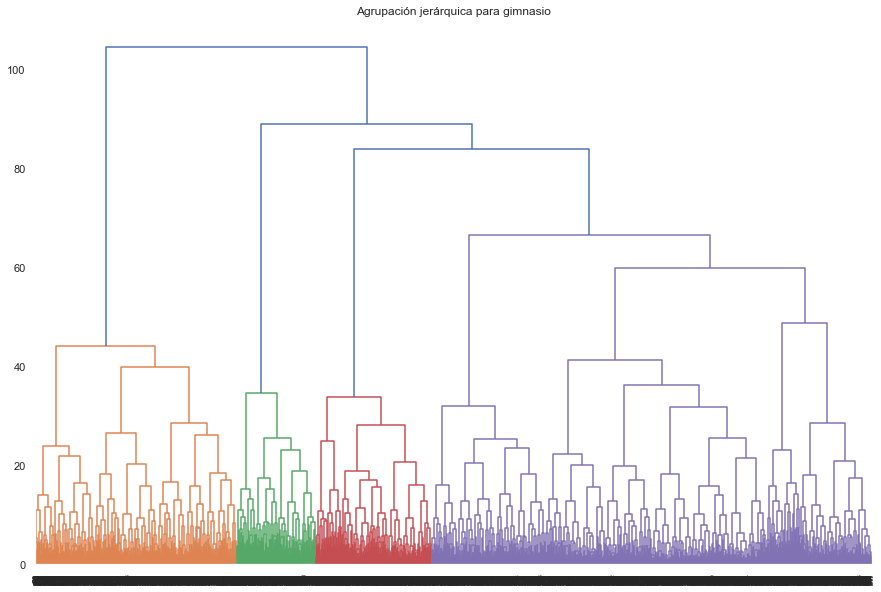

In [15]:
# Estandarizar los datos
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Matriz de distancias
linked = linkage(X_sc, method = 'ward')

# Dendrograma
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para gimnasio')
plt.show()

Como podemos observar en la gráfica, el número optimo de clusters es de 4; sin embargo el ultimo grupo se puede separar todavia por lo que agregaremos uno más dejando en 5 nuestro numero de clusters a dividir

In [16]:
# Creacion de clusters
km = KMeans(n_clusters = 5) # establecer el número de clústeres en 5
labels = km.fit_predict(X_sc) # aplicar el algoritmo a los datos y formar un vector de clúster

In [17]:
# Unimos los clusters identificados al dataframe
data['clusters'] = labels

# Valores medios para las caracteristicas de los clusters
data.groupby('clusters').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
clusters,,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
2,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
3,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


Viendo los datos medios de las caracteriticas podemos notar lo siguiente:

- Tenemos un cluster que no tiene ninguna persona cerca a la locacion `1` y otro que todos sus usuarios estan cerca de la locacion `3`, los demas tienen un poco de ambos grupos.
- Tenemos 4 grupos donde todos los clientes colocaron celular vs un cluster donde ningun cliente coloco celular
- Nuestros clusters van desde los 28 años en promedio a los 30 años
- Tenemos un cluster con un promedio de 3 clases a la semana (tanto por mes como por tiempo de vida) y los demas van desde 1 a 2 en promedio a la semana

In [18]:
# Vemos la tasa de cancelacion para cada cluster
data.groupby('clusters').churn.mean()

clusters
0    0.267532
1    0.027695
2    0.514263
3    0.443564
4    0.068100
Name: churn, dtype: float64

Podemos ver que los clusters `1` y `3` tienen un 44% y un 51% de usuarios que abandonaron, por lo que son los clusters que son más propensos a irse (cabe destacar que el grupo `1` era el grupo donde ningun miembro vivia cerca de la locacion mientras que el `3` es el grupo donde todos sus usarios vivian cerca de la locacion; en general en estos grupos su periodo de contrato era en promedio de 2 meses, son de los grupos de menor edad en promedio con 28 años, son los 2 grupos que menos ha gastado extra en otros servicios, solo realizan en promedio una clase a la semana y su tiempo de vida en general es de 2 meses) mientras que los grupos `0`  y `4` son los más leales (estos grupos en general la mayoria de los usuarios viven cerca de la locacion, son de los grupos que mayor visitas en grupo hacen, son de los que más gastan en extras y su tiempo de vida es el más largo con 5 meses, uno de ellos [`4`] tiene un gran numero de usuarios que son empleados de oficina, realizaron la promocion del amigo, su tiempo de contrato es de 11 meses en promedio)

## Conclusiones y recomendaciones<a id="conclusiones_recomendaciones"></a>

### Conclusiones

Una vez realizado el análisis pudimos llegar a las siguientes conclusiones:

1. Aunque el hecho de que las personas que viven lejos de la locacion tienen tendencia a cancelar, el que vivan cerca no nos garantiza que se queden por lo que es una métrica que no se debe priorizar, sin embargo no se debe dejar de lado de todo. La consideramos de prioridad secundaria
2. La caracteristica de telefono no es una métrica relevante para la retencion de clientes por lo que su prioridad es minima en su recoleccion
3. Se identifico que los usuarios con largos periodos de contrato tienden a seguir adelante sin embargo uno de nuestros grupos más leales tienen en promedio 2 meses de contrato por lo que se deberia considerar una metrica secundaria
4. Se identifico que los usuarios que realizan mayores gastos en extras del gimnasio y que superan el tiempo de vida de 4 meses tienden a desarrollar lealtad por el gimnasio y continuan el contrato; por lo que consideramos que estas metricas son prioritarias para el modelo.
5. Se identifico que los clientes que realizan mayores visitas en grupo pertenecen a los clusters más leales que los que lo hacen con menor frecuencia por lo que se debe explorar esta métrica más a fondo para la retencion
6. Se identifico que los grupos que realizan 2 o más clases a la semana tienden a permanecer más que los que solo hacen una, por lo que se deberia impulsar a los usuarios a realizar más dias.

### Recomendaciones

- A pesar de considerarse una metrica secundaria, se deberia buscar que los usuarios realizen contratos a largo plazo con alguna promoción o beneficio extra.
- Con el objetivo de impulsar a los usuarios a pasar de la barrera de los 4 meses de tiempo de vida, recomendamos analizar posibles beneficios para los usuarios que superen este tiempo y asi animarlos a continuar
- Las visitas en grupo parece ser una métrica que impulsa a la retención por lo que recomendamos realizar más analisis poniendo esta métrica a prueba, incluso de ser posible un test a/b
- Con el objetivo de que los usuarios asistan más dias a la semana, recomendamos impulsar más a los usuarios de aprovechar su membresia o incluso colocando actividades extra que animen al usuario a regresar varios dias
- Con el objetivo de que los usuarios realizen más gastos en los servicios extras, recomendamos analizar que servicios nuevos se pueden añadir o realizar un analisis de que servicios son los más populares e impulsarlos